In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Import data

In [2]:
dataset = pd.read_csv('winequality-white.csv', sep=';')
dataset.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


Split data into training and testing datasets

In [3]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Get training data stats

In [4]:
train_stats = train_dataset.describe()
train_stats.pop("quality")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3918.0,6.858754,0.855479,4.20000,6.300000,6.80000,7.3000,14.20000
volatile acidity,3918.0,0.278278,0.100173,0.08000,0.210000,0.26000,0.3200,1.00500
citric acid,3918.0,0.334722,0.122170,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,3918.0,6.380028,5.057262,0.60000,1.700000,5.20000,9.8500,65.80000
chlorides,3918.0,0.045709,0.022408,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,3918.0,35.172282,17.139453,2.00000,23.000000,34.00000,45.0000,289.00000
total sulfur dioxide,3918.0,137.688999,42.577736,9.00000,107.000000,133.50000,166.0000,440.00000
density,3918.0,0.994021,0.002987,0.98711,0.991753,0.99373,0.9961,1.03898
pH,3918.0,3.187412,0.151155,2.72000,3.080000,3.18000,3.2800,3.82000
sulphates,3918.0,0.489104,0.114159,0.23000,0.410000,0.47500,0.5500,1.08000


Pop training and testing labels

In [5]:
train_labels = train_dataset.pop('quality')
test_labels = test_dataset.pop('quality')

Normalize data

In [6]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build and compile model

In [7]:
model = keras.Sequential([
  layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
  layers.Dense(64, activation='relu'),
  layers.Dense(11, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Create early stop callback

In [8]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Train model

In [9]:
history = model.fit(normed_train_data, train_labels, 
                    epochs=100, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop])

Check model's performance history

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
24,0.897379,0.613912,1.052303,0.563776,24
25,0.892508,0.614231,1.049838,0.557398,25
26,0.886683,0.613912,1.050762,0.566327,26
27,0.878171,0.616784,1.054217,0.567602,27
28,0.876912,0.619655,1.060440,0.545918,28


Evaluate model

In [11]:
loss, accuracy = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set accuracy: {:5.2f}".format(accuracy))

31/31 - 0s - loss: 1.0282 - accuracy: 0.5510
Testing set accuracy:  0.55


Plot predictions versus true labels

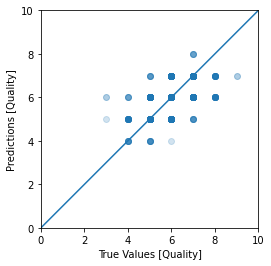

In [12]:
test_predictions = model.predict(normed_test_data)
test_predictions = np.argmax(test_predictions, axis=1)

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, alpha=0.2)
plt.xlabel('True Values [Quality]')
plt.ylabel('Predictions [Quality]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)